<a href="https://colab.research.google.com/github/anshulchauhan502/btp/blob/main/ver1_b4_only_transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Put your dataset under this base path. Edit if you placed it elsewhere.
DRIVE_BASE = '/content/drive/MyDrive'
HAM_DIR = f'{DRIVE_BASE}/ham10000'   # <- put your files here
print("Expected dataset folder:", HAM_DIR)


Mounted at /content/drive
Expected dataset folder: /content/drive/MyDrive/ham10000


In [5]:
# Cell 2: Unzip HAM10000 dataset (zip is directly in MyDrive)
import zipfile
import os

zip_path = "/content/drive/MyDrive/ham10000.zip"   # directly in MyDrive
extract_path = "/content/drive/MyDrive/ham10000_data/"  # make a clean folder for extracted files

# Make sure the folder exists
os.makedirs(extract_path, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Dataset unzipped successfully!")
print("📂 Extracted items:", os.listdir(extract_path))


✅ Dataset unzipped successfully!
📂 Extracted items: ['HAM10000_images_part_1', 'HAM10000_images_part_2', 'HAM10000_metadata.csv', 'ham10000_images_part_1', 'ham10000_images_part_2', 'hmnist_28_28_L.csv', 'hmnist_28_28_RGB.csv', 'hmnist_8_8_L.csv', 'hmnist_8_8_RGB.csv']


In [6]:
# Cell 2: Environment checks (TF version, GPU)
import sys, subprocess, os, json
import tensorflow as tf
import numpy as np
import platform

print("Python:", sys.version.splitlines()[0])
print("Platform:", platform.platform())
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__)

# GPU info (if available)
try:
    gpu_list = tf.config.list_physical_devices('GPU')
    print("GPUs found:", gpu_list)
    # optional: nvidia-smi (works on standard Colab GPU runtimes)
    !nvidia-smi -L || true
except Exception as e:
    print("GPU check failed:", e)

# Warnings and notes:
print("\nNotes:")
print("- We will use tf.keras.applications.EfficientNetB4 (TF builtin).")
print("- If TF version < 2.6 or very old, tell me and I can provide a pin/install cell.")


Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Platform: Linux-6.6.97+-x86_64-with-glibc2.35
TensorFlow version: 2.19.0
Keras version: 3.10.0
GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU 0: Tesla T4 (UUID: GPU-26d8cc76-5e00-7e22-a4b4-3a55acc11869)

Notes:
- We will use tf.keras.applications.EfficientNetB4 (TF builtin).
- If TF version < 2.6 or very old, tell me and I can provide a pin/install cell.


In [7]:
# Cell 4: imports, seed, and helper functions
import os, random, math, shutil
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# reproducibility (note: full determinism is hard on GPU)
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

AUTOTUNE = tf.data.AUTOTUNE
print("Imports ready.")


Imports ready.


In [8]:
# Cell 5: Dataset locating + label mapping (updated for your setup)
import os
import pandas as pd
from glob import glob

# Base directory where you extracted HAM10000
HAM_DIR = "/content/drive/MyDrive/ham10000_data/"

# Folders containing images
img_folder_candidates = [
    os.path.join(HAM_DIR, 'HAM10000_images_part_1'),
    os.path.join(HAM_DIR, 'HAM10000_images_part_2'),
    os.path.join(HAM_DIR, 'ham10000_images_part_1'),  # lowercase variants just in case
    os.path.join(HAM_DIR, 'ham10000_images_part_2')
]

# Metadata CSV path
metadata_path = os.path.join(HAM_DIR, "HAM10000_metadata.csv")
print("Using metadata CSV:", metadata_path)

# Load metadata
meta = pd.read_csv(metadata_path)
meta.columns = [c.strip() for c in meta.columns]
print("Columns in metadata:", meta.columns.tolist())

# Detect lesion column (usually 'dx')
label_col = None
for candidate in ['dx', 'label', 'diagnosis', 'dx_type']:
    if candidate in meta.columns:
        label_col = candidate
        break
if label_col is None:
    raise ValueError("Could not find diagnosis column in CSV. Expected 'dx' or similar.")
print("Detected lesion column:", label_col)

# Map lesion types to binary labels (malignant=1, benign=0)
malignant_labels = ['mel', 'bcc', 'akiec']  # you can modify if needed
def to_binary(dx):
    try:
        return 1 if str(dx).lower() in malignant_labels else 0
    except:
        return 0

meta['binary_label'] = meta[label_col].apply(to_binary)

# Detect image_id column
img_id_col = None
for c in ['image_id', 'img_id', 'image', 'id']:
    if c in meta.columns:
        img_id_col = c
        break
if img_id_col is None:
    raise ValueError("Could not detect image id column. Please ensure CSV has image IDs.")

# Function to resolve full image path
def resolve_path(imgid):
    for folder in img_folder_candidates:
        for ext in ['.jpg', '.jpeg', '.png']:
            p = os.path.join(folder, f"{imgid}{ext}")
            if os.path.exists(p):
                return p
    # fallback: search globally in candidate folders
    for folder in img_folder_candidates:
        found = glob(os.path.join(folder, f"*{imgid}*"))
        if len(found) > 0:
            return found[0]
    return None  # if not found

meta['image_path'] = meta[img_id_col].astype(str).apply(resolve_path)

# Drop rows with missing images
missing = meta['image_path'].isna().sum()
print(f"Total rows: {len(meta)} ; missing image paths: {missing}")
meta = meta.dropna(subset=['image_path']).reset_index(drop=True)
print("Final usable samples:", len(meta))
print("Label counts:\n", meta['binary_label'].value_counts())


Using metadata CSV: /content/drive/MyDrive/ham10000_data/HAM10000_metadata.csv
Columns in metadata: ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization']
Detected lesion column: dx
Total rows: 10015 ; missing image paths: 0
Final usable samples: 10015
Label counts:
 binary_label
0    8061
1    1954
Name: count, dtype: int64


In [10]:
# Cell 6: Prepare dataset and EfficientNet-B4 transfer learning
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ------------------------------
# Step 1: Split dataset
# ------------------------------
# 70% train, 20% validation, 10% test
train_df, temp_df = train_test_split(meta, test_size=0.3, stratify=meta['binary_label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.33, stratify=temp_df['binary_label'], random_state=42)

print(f"Train samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(test_df)}")



# Convert binary_label to string for Keras
train_df['binary_label'] = train_df['binary_label'].astype(str)
val_df['binary_label'] = val_df['binary_label'].astype(str)
test_df['binary_label'] = test_df['binary_label'].astype(str)

# ------------------------------
# Step 2: Image data generators with augmentation
# ------------------------------
IMG_SIZE = (380, 380)  # EfficientNet-B4 input size
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# ------------------------------
# Step 3: Flow from dataframe
# ------------------------------
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='binary_label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='binary_label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='binary_label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

# ------------------------------
# Step 4: Load EfficientNet-B4 pretrained on ImageNet
# ------------------------------
base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # freeze base for initial training

# ------------------------------
# Step 5: Add custom classification head
# ------------------------------
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)  # binary classification

model = Model(inputs=base_model.input, outputs=x)

# ------------------------------
# Step 6: Compile model
# ------------------------------
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ------------------------------
# Step 7: Train model
# ------------------------------
EPOCHS = 5  # start small for testing, can increase later

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# ------------------------------
# Step 8: Evaluate on test set
# ------------------------------
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Accuracy: {test_acc*100:.2f}%")


Train samples: 7010, Validation samples: 2013, Test samples: 992
Found 7010 validated image filenames belonging to 2 classes.
Found 2013 validated image filenames belonging to 2 classes.
Found 992 validated image filenames belonging to 2 classes.
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 380, 380,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 380, 380,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 380, 380,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 380, 380,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 381, 381,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 190, 190,  │      1,296 │ stem_conv_pad[0]… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 190, 190,  │        192 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 190, 190,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 190, 190,  │        432 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 190, 190,  │        192 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 190, 190,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 48)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 48)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 12)  │        588 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 48)  │        624 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 190, 190,  │          0 │ block1a_activati… │
│ (Multiply)          │ 48)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 190, 190,  │      1,152 │ block1a_se_excit

 Total params: 18,133,088 (69.17 MB)

 Trainable params: 459,265 (1.75 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 474s 948ms/step - accuracy: 0.8000 - loss: 0.5002 - val_accuracy: 0.8048 - val_loss: 0.4941
Epoch 2/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 331s 754ms/step - accuracy: 0.7998 - loss: 0.5064 - val_accuracy: 0.8048 - val_loss: 0.4992
Epoch 3/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 319s 728ms/step - accuracy: 0.8049 - loss: 0.4991 - val_accuracy: 0.8048 - val_loss: 0.4937
Epoch 4/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 322s 732ms/step - accuracy: 0.8003 - loss: 0.5065 - val_accuracy: 0.8048 - val_loss: 0.4940
Epoch 5/5
439/439 ━━━━━━━━━━━━━━━━━━━━ 321s 732ms/step - accuracy: 0.7982 - loss: 0.5077 - val_accuracy: 0.8048 - val_loss: 0.5027
62/62 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.7921 - loss: 0.5165
Test Accuracy: 80.54%


In [11]:
# Cell 7: model builder, compile and show summary
from tensorflow.keras.applications import EfficientNetB4

def build_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), base_trainable=False):
    base = EfficientNetB4(include_top=False, input_shape=input_shape, weights='imagenet', pooling='avg')
    base.trainable = base_trainable
    inputs = keras.Input(shape=input_shape)
    # data augmentation as a layer (optional - we already did some augmentation in dataset)
    x = layers.RandomFlip('horizontal_and_vertical')(inputs)
    x = layers.RandomRotation(0.15)(x)
    x = layers.RandomZoom(0.1)(x)
    # preprocess (note: dataset already preprocessed; if you remove dataset preprocess, use this)
    # x = tf.keras.applications.efficientnet.preprocess_input(x)
    x = base(x, training=False)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs, outputs, name='effnetb4_skinclf')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[keras.metrics.AUC(name='auc'), 'accuracy']
    )
    return model

model = build_model(base_trainable=False)
model.summary()


Model: "effnetb4_skinclf"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 380, 380, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 380, 380, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       459,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,134,112 (69.18 MB)

 Trainable params: 459,777 (1.75 MB)

 Non-trainable params: 17,674,335 (67.42 MB)

In [12]:
# Cell 8: callbacks and training (run when ready)
EPOCHS = 8   # start small; increase later for final runs
MODEL_DIR = os.path.join(HAM_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)
BEST_WEIGHTS = os.path.join(MODEL_DIR, 'best_effnetb4_weights.h5')
SAVED_MODEL_DIR = os.path.join(MODEL_DIR, 'effnetb4_savedmodel')

callbacks = [
    keras.callbacks.ModelCheckpoint(BEST_WEIGHTS, monitor='val_auc', mode='max', save_best_only=True, save_weights_only=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1),
    keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=4, restore_best_weights=True, verbose=1)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save final weights and SavedModel safely
model.save_weights(os.path.join(MODEL_DIR, 'final_weights.h5'))
try:
    model.save(SAVED_MODEL_DIR)  # default SavedModel format
    print("Saved full model to:", SAVED_MODEL_DIR)
except Exception as e:
    print("model.save() raised:", e)
    print("Saved weights only as fallback.")


ValueError: When using `save_weights_only=True` in `ModelCheckpoint`, the filepath provided must end in `.weights.h5` (Keras weights format). Received: filepath=/content/drive/MyDrive/ham10000_data/models/best_effnetb4_weights.h5

In [13]:
# Cell 6 (fixed): callbacks and training
EPOCHS = 8   # start small; increase later for final runs
MODEL_DIR = os.path.join(HAM_DIR, 'models')
os.makedirs(MODEL_DIR, exist_ok=True)

# Must end in .weights.h5 (Keras 3 requirement)
BEST_WEIGHTS = os.path.join(MODEL_DIR, 'best_effnetb4.weights.h5')
SAVED_MODEL_DIR = os.path.join(MODEL_DIR, 'effnetb4_savedmodel')

callbacks = [
    keras.callbacks.ModelCheckpoint(
        BEST_WEIGHTS,
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        save_weights_only=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_auc',
        mode='max',
        patience=4,
        restore_best_weights=True,
        verbose=1
    )
]

# ✅ Use train_generator and val_generator, not train_ds/val_ds
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Save final weights and SavedModel safely
model.save_weights(os.path.join(MODEL_DIR, 'final.weights.h5'))  # must also end in .weights.h5
try:
    model.save(SAVED_MODEL_DIR)  # default SavedModel format
    print("Saved full model to:", SAVED_MODEL_DIR)
except Exception as e:
    print("model.save() raised:", e)
    print("Saved weights only as fallback.")


Epoch 1/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 723ms/step - accuracy: 0.5407 - auc: 0.5030 - loss: 0.8425
Epoch 1: val_auc improved from -inf to 0.50061, saving model to /content/drive/MyDrive/ham10000_data/models/best_effnetb4.weights.h5
439/439 ━━━━━━━━━━━━━━━━━━━━ 386s 820ms/step - accuracy: 0.5408 - auc: 0.5030 - loss: 0.8423 - val_accuracy: 0.8048 - val_auc: 0.5006 - val_loss: 0.6408 - learning_rate: 1.0000e-04
Epoch 2/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 724ms/step - accuracy: 0.6611 - auc: 0.4701 - loss: 0.6505
Epoch 2: val_auc improved from 0.50061 to 0.50364, saving model to /content/drive/MyDrive/ham10000_data/models/best_effnetb4.weights.h5
439/439 ━━━━━━━━━━━━━━━━━━━━ 369s 802ms/step - accuracy: 0.6612 - auc: 0.4701 - loss: 0.6504 - val_accuracy: 0.8048 - val_auc: 0.5036 - val_loss: 0.5111 - learning_rate: 1.0000e-04
Epoch 3/8
439/439 ━━━━━━━━━━━━━━━━━━━━ 0s 722ms/step - accuracy: 0.7600 - auc: 0.4865 - loss: 0.5627
Epoch 3: val_auc improved from 0.50364 to 0.50630, saving model to

126/126 ━━━━━━━━━━━━━━━━━━━━ 38s 291ms/step - accuracy: 0.8133 - auc: 0.5411 - loss: 0.4815
Validation metrics (loss, auc, acc): [0.4936941862106323, 0.5590165853500366, 0.804768979549408]
63/63 ━━━━━━━━━━━━━━━━━━━━ 46s 595ms/step
Val AUC: 0.6811107969716961

Classification report:
               precision    recall  f1-score   support

           0     0.9476    0.2679    0.4177      1620
           1     0.2373    0.9389    0.3789       393

    accuracy                         0.3989      2013
   macro avg     0.5924    0.6034    0.3983      2013
weighted avg     0.8089    0.3989    0.4101      2013

Confusion matrix:
 [[ 434 1186]
 [  24  369]]


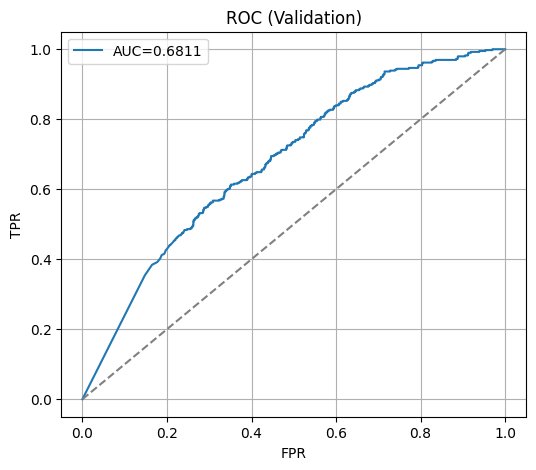

In [14]:
# Load best weights saved via ModelCheckpoint
model.load_weights(BEST_WEIGHTS)

# Evaluate on validation generator (not val_ds)
res = model.evaluate(val_generator)
print("Validation metrics (loss, auc, acc):", res)

# Get true labels
y_true = val_df['binary_label'].astype(int).values  # fix: convert from string to int

# Build inference dataset from file paths (as an alternative to val_generator)
val_paths = val_df['image_path'].values

def infer_ds_from_paths(paths, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(paths)
    def _load(path):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, IMG_SIZE)
        img = tf.keras.applications.efficientnet.preprocess_input(img)
        return img
    ds = ds.map(_load, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
    return ds

# Predict on the preprocessed images
inf_ds = infer_ds_from_paths(val_paths, batch_size=32)
y_pred_probs = model.predict(inf_ds).ravel()
y_pred = (y_pred_probs >= 0.5).astype(int)

# AUC, classification report, confusion matrix
auc = roc_auc_score(y_true, y_pred_probs)
print("Val AUC:", auc)
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=4))
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

# ROC curve plot
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'AUC={auc:.4f}')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC (Validation)')
plt.legend(); plt.grid(True)
plt.show()
